# MLP on the CIFAR-10 Dataset

Trains three simple NNs with 3 hidden layers on the CIFAR-10 dataset.

Gets to ~46% validation accuracy after 100 epochs (mean squared loss) (Residual Connection)

Gets to ~47% validation accuracy after 100 epochs (mean squared loss) (MLP)

Gets to ~52% validation accuracy after 100 epochs (cross-entropy loss) (MLP)

(there is *a lot* of margin for parameter tuning).

~ 6 seconds per epoch on a GTX1070 GPU.


## Import Tensorflow package (for Keras) and the CIFAR-10 dataset

In [1]:
from __future__ import print_function

# import keras
# from keras.datasets import mnist
# from keras.models import Sequential
# from keras.layers import Dense, Dropout
# from keras.optimizers import RMSprop
# from keras import regularizers

import tensorflow as tf

batch_size = 512
num_classes = 10
epochs = 100

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

#print(x_train[0,0:10,0,0])

50000 train samples
10000 test samples


## Visualize Some Training Samples

The first 5 images, followed by 25 random images:


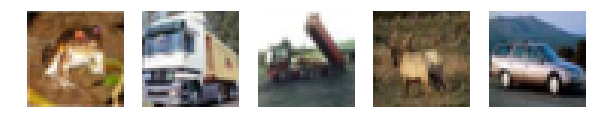

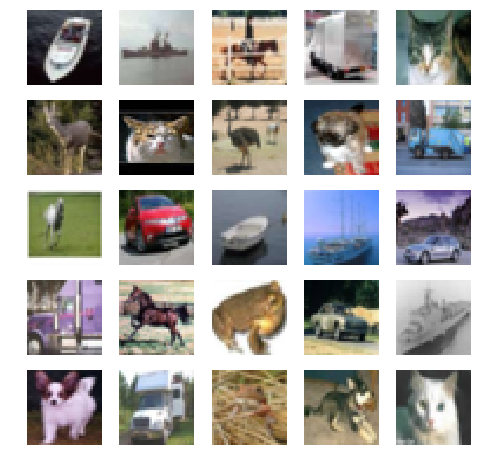

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


fig, axes = plt.subplots(1,5,figsize=(10,10))
print('The first 5 images, followed by 25 random images:')
for i in range(5):
    axes[i].set_axis_off()
    axes[i].imshow(x_train[i], interpolation='nearest')

fig1, axes1 = plt.subplots(5,5,figsize=(8,8))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(x_train)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(x_train[i:i+1][0], interpolation='nearest')

## Data Transformation

In [3]:
x_train = x_train.reshape((50000, 3*32*32), order='F') # reshaping order fixed to the same as BCD
x_test = x_test.reshape((10000, 3*32*32), order='F') # reshaping order fixed to the same as BCD
#print(x_train[0,0:10])
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# The First Model (Residual Connection)

## Model Setup

Input -> Fully Connected (3072) -> ReLU -> Fully Connected (3072) -> Add Input -> ReLU -> Fully Connected (3072) -> ReLU -> Fully Connected (10) -> Mean squared loss

In [4]:
# model
x1 = tf.keras.layers.Input(shape=(3072,))
a1 = tf.keras.layers.Dense(3072, activation='relu', use_bias=True)(x1)
a2 = tf.keras.layers.Dense(3072, activation='relu', use_bias=True)(a1)
a2 = tf.keras.layers.Add()([a2, x1])
a3 = tf.keras.layers.Dense(3072, activation='relu', use_bias=True)(a2)
y_mlp = tf.keras.layers.Dense(num_classes, activation=None, use_bias=True)(a3)
#y_mlp = tf.keras.layers.Dense(num_classes, activation='softmax', use_bias=True, kernel_regularizer=tf.keras.regularizers.l2(l=0.01))(a3)

model = tf.keras.models.Model(inputs=x1, outputs=y_mlp)

model.summary()

model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3072)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3072)         9440256     input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 3072)         9440256     dense_1[0][0]                    
__________________________________________________________________________________________________
add_1 (Add)                     (None, 3072)         0           dense_2[0][0]                    
                                                                 input_1[0][0]                    
__________

## Fit the Model using Back Propagation (Vanilla SGD)

In [5]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
#print('Test error:', 1-score[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================]50000/50000 [==============================] - 7s 142us/step - loss: 0.5929 - acc: 0.1966 - val_loss: 0.0875 - val_acc: 0.2498

Epoch 2/100
50000/50000 [==============================]50000/50000 [==============================] - 5s 109us/step - loss: 0.0862 - acc: 0.2742 - val_loss: 0.0850 - val_acc: 0.2957

Epoch 3/100
50000/50000 [==============================]50000/50000 [==============================] - 5s 110us/step - loss: 0.0842 - acc: 0.3089 - val_loss: 0.0836 - val_acc: 0.3175

Epoch 4/100
50000/50000 [==============================]50000/50000 [==============================] - 6s 110us/step - loss: 0.0830 - acc: 0.3293 - val_loss: 0.0826 - val_acc: 0.3315

Epoch 5/100
50000/50000 [==============================]50000/50000 [==============================] - 6s 111us/step - loss: 0.0820 - acc: 0.3423 - val_loss: 0.0818 - val_acc: 0.3445

Epoch 6/100
50000/50000 [=====

50000/50000 [==============================]50000/50000 [==============================] - 6s 110us/step - loss: 0.0735 - acc: 0.4535 - val_loss: 0.0748 - val_acc: 0.4352

Epoch 46/100
50000/50000 [==============================]50000/50000 [==============================] - 6s 110us/step - loss: 0.0734 - acc: 0.4546 - val_loss: 0.0747 - val_acc: 0.4357

Epoch 47/100
50000/50000 [==============================]50000/50000 [==============================] - 5s 110us/step - loss: 0.0733 - acc: 0.4564 - val_loss: 0.0746 - val_acc: 0.4351

Epoch 48/100
50000/50000 [==============================]50000/50000 [==============================] - 6s 110us/step - loss: 0.0732 - acc: 0.4570 - val_loss: 0.0746 - val_acc: 0.4328

Epoch 49/100
50000/50000 [==============================]50000/50000 [==============================] - 6s 110us/step - loss: 0.0731 - acc: 0.4571 - val_loss: 0.0745 - val_acc: 0.4367

Epoch 50/100
50000/50000 [==============================]50000/50000 [==================

50000/50000 [==============================]50000/50000 [==============================] - 6s 111us/step - loss: 0.0704 - acc: 0.4899 - val_loss: 0.0726 - val_acc: 0.4566

Epoch 90/100
50000/50000 [==============================]50000/50000 [==============================] - 5s 110us/step - loss: 0.0704 - acc: 0.4920 - val_loss: 0.0726 - val_acc: 0.4581

Epoch 91/100
50000/50000 [==============================]50000/50000 [==============================] - 5s 110us/step - loss: 0.0703 - acc: 0.4915 - val_loss: 0.0725 - val_acc: 0.4583

Epoch 92/100
50000/50000 [==============================]50000/50000 [==============================] - 5s 109us/step - loss: 0.0703 - acc: 0.4912 - val_loss: 0.0725 - val_acc: 0.4597

Epoch 93/100
50000/50000 [==============================]50000/50000 [==============================] - 5s 109us/step - loss: 0.0702 - acc: 0.4920 - val_loss: 0.0725 - val_acc: 0.4592

Epoch 94/100
50000/50000 [==============================]50000/50000 [==================

## Loss and Accuracy Plots

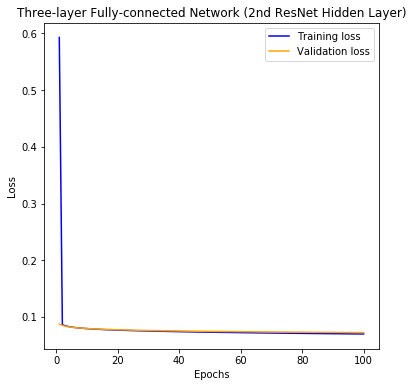

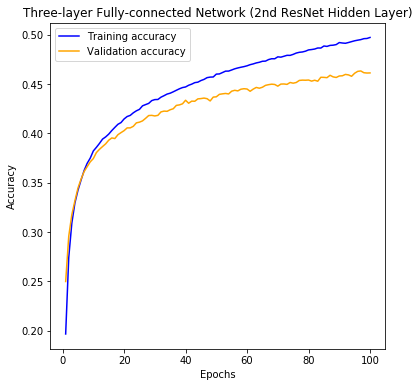

In [6]:
# Plot of Losses
history_dict = history.history
# history_dict.keys()
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

epochs_index = range(1,len(loss_values)+1)

fig_loss = plt.figure(figsize=(6, 6))
plt.plot(epochs_index, loss_values, 'b', label='Training loss')
plt.plot(epochs_index, val_loss_values, 'b', c='orange', label='Validation loss')
plt.title('Three-layer Fully-connected Network (2nd ResNet Hidden Layer)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



#%%
# Plot of Accuracies
plt.clf()
fig_accuracy = plt.figure(figsize=(6, 6))
plt.plot(epochs_index,acc_values,'b', label='Training accuracy')
plt.plot(epochs_index,val_acc_values,'b', c='orange', label='Validation accuracy')
plt.title('Three-layer Fully-connected Network (2nd ResNet Hidden Layer)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [7]:
fig_accuracy.savefig('fig_accuracy_cifar.eps', format='eps', dpi=2000)

# The Second Model (MLP)

## Model Setup

Input -> Fully Connected (3072) -> ReLU -> Fully Connected (3072) -> ReLU -> Fully Connected (3072) -> ReLU -> Fully Connected (10) -> Mean squared loss

In [8]:
# model
x0 = tf.keras.layers.Input(shape=(3072,))
u1 = tf.keras.layers.Dense(3072, activation='relu', use_bias=True)(x0)
u2 = tf.keras.layers.Dense(3072, activation='relu', use_bias=True)(u1)
u3 = tf.keras.layers.Dense(3072, activation='relu', use_bias=True)(u2)
y_mlp_2 = tf.keras.layers.Dense(num_classes, activation=None, use_bias=True)(u3)
#y_mlp = tf.keras.layers.Dense(num_classes, activation='softmax', use_bias=True, kernel_regularizer=tf.keras.regularizers.l2(l=0.01))(a3)

model_2 = tf.keras.models.Model(inputs=x0, outputs=y_mlp_2)

model_2.summary()

model_2.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 3072)              9440256   
_________________________________________________________________
dense_6 (Dense)              (None, 3072)              9440256   
_________________________________________________________________
dense_7 (Dense)              (None, 3072)              9440256   
_________________________________________________________________
dense_8 (Dense)              (None, 10)                30730     
Total params: 28,351,498
Trainable params: 28,351,498
Non-trainable params: 0
_________________________________________________________________


## Fit the Model using Back Propagation (Vanilla SGD)

In [9]:
history_2 = model_2.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score_2 = model_2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score_2[0])
print('Test accuracy:', score_2[1])
#print('Test error:', 1-score[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================]50000/50000 [==============================] - 6s 114us/step - loss: 0.0907 - acc: 0.2023 - val_loss: 0.0858 - val_acc: 0.2669

Epoch 2/100
50000/50000 [==============================]50000/50000 [==============================] - 5s 109us/step - loss: 0.0844 - acc: 0.2933 - val_loss: 0.0833 - val_acc: 0.3117

Epoch 3/100
50000/50000 [==============================]50000/50000 [==============================] - 5s 109us/step - loss: 0.0824 - acc: 0.3264 - val_loss: 0.0820 - val_acc: 0.3354

Epoch 4/100
50000/50000 [==============================]50000/50000 [==============================] - 5s 109us/step - loss: 0.0812 - acc: 0.3470 - val_loss: 0.0809 - val_acc: 0.3494

Epoch 5/100
50000/50000 [==============================]50000/50000 [==============================] - 5s 110us/step - loss: 0.0803 - acc: 0.3633 - val_loss: 0.0803 - val_acc: 0.3622

Epoch 6/100
50000/50000 [=====

50000/50000 [==============================]50000/50000 [==============================] - 5s 110us/step - loss: 0.0719 - acc: 0.4713 - val_loss: 0.0734 - val_acc: 0.4477

Epoch 46/100
50000/50000 [==============================]50000/50000 [==============================] - 6s 110us/step - loss: 0.0718 - acc: 0.4713 - val_loss: 0.0733 - val_acc: 0.4450

Epoch 47/100
50000/50000 [==============================]50000/50000 [==============================] - 5s 110us/step - loss: 0.0717 - acc: 0.4723 - val_loss: 0.0732 - val_acc: 0.4530

Epoch 48/100
50000/50000 [==============================]50000/50000 [==============================] - 5s 110us/step - loss: 0.0717 - acc: 0.4749 - val_loss: 0.0734 - val_acc: 0.4491

Epoch 49/100
50000/50000 [==============================]50000/50000 [==============================] - 6s 110us/step - loss: 0.0716 - acc: 0.4749 - val_loss: 0.0733 - val_acc: 0.4492

Epoch 50/100
50000/50000 [==============================]50000/50000 [==================

50000/50000 [==============================]50000/50000 [==============================] - 6s 115us/step - loss: 0.0689 - acc: 0.5048 - val_loss: 0.0712 - val_acc: 0.4712

Epoch 90/100
50000/50000 [==============================]50000/50000 [==============================] - 6s 116us/step - loss: 0.0689 - acc: 0.5057 - val_loss: 0.0713 - val_acc: 0.4674

Epoch 91/100
50000/50000 [==============================]50000/50000 [==============================] - 6s 115us/step - loss: 0.0688 - acc: 0.5063 - val_loss: 0.0713 - val_acc: 0.4699

Epoch 92/100
50000/50000 [==============================]50000/50000 [==============================] - 6s 115us/step - loss: 0.0687 - acc: 0.5065 - val_loss: 0.0713 - val_acc: 0.4683

Epoch 93/100
50000/50000 [==============================]50000/50000 [==============================] - 6s 117us/step - loss: 0.0687 - acc: 0.5074 - val_loss: 0.0712 - val_acc: 0.4705

Epoch 94/100
50000/50000 [==============================]50000/50000 [==================

## Loss and Accuracy Plots

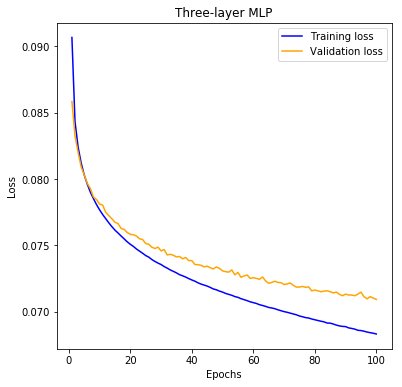

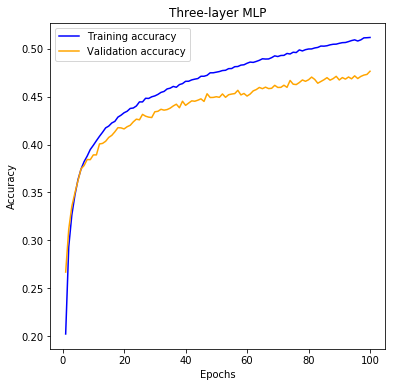

In [10]:
# Plot of Losses
history_dict_2 = history_2.history
# history_dict.keys()
loss_values_2 = history_dict_2['loss']
val_loss_values_2 = history_dict_2['val_loss']
acc_values_2 = history_dict_2['acc']
val_acc_values_2 = history_dict_2['val_acc']

epochs_index = range(1,len(loss_values_2)+1)
fig_loss_2 = plt.figure(figsize=(6, 6))
plt.plot(epochs_index, loss_values_2, 'b', label='Training loss')
plt.plot(epochs_index, val_loss_values_2, 'b', c='orange', label='Validation loss')
plt.title('Three-layer MLP')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



#%%
# Plot of Accuracies
plt.clf()
fig_accuracy_2 = plt.figure(figsize=(6, 6))
plt.plot(epochs_index,acc_values_2,'b', label='Training accuracy')
plt.plot(epochs_index,val_acc_values_2,'b', c='orange', label='Validation accuracy')
plt.title('Three-layer MLP')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Save the Plots

In [11]:
fig_accuracy_2.savefig('fig_accuracy_cifar_2.eps', format='eps', dpi=2000)

# The Third Model (MLP) (Cross-entropy Loss)

Input -> Fully Connected (3072) -> ReLU -> Fully Connected (3072) -> ReLU -> Fully Connected (3072) -> ReLU -> Fully Connected (10) -> Softmax -> Cross-entropy loss

In [12]:
# model
z0 = tf.keras.layers.Input(shape=(3072,))
z1 = tf.keras.layers.Dense(3072, activation='relu', use_bias=True)(z0)
z2 = tf.keras.layers.Dense(3072, activation='relu', use_bias=True)(z1)
z3 = tf.keras.layers.Dense(3072, activation='relu', use_bias=True)(z2)
#y_mlp_2 = tf.keras.layers.Dense(num_classes, activation=None, use_bias=True)(z3)
y_mlp_3 = tf.keras.layers.Dense(num_classes, activation='softmax', use_bias=True, kernel_regularizer=None)(z3)

model_3 = tf.keras.models.Model(inputs=z0, outputs=y_mlp_3)

model_3.summary()

model_3.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 3072)              9440256   
_________________________________________________________________
dense_10 (Dense)             (None, 3072)              9440256   
_________________________________________________________________
dense_11 (Dense)             (None, 3072)              9440256   
_________________________________________________________________
dense_12 (Dense)             (None, 10)                30730     
Total params: 28,351,498
Trainable params: 28,351,498
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
keep_dims is deprecated, use keepdims instead


## Fit the Model using Back Propagation (Vanilla SGD)

In [13]:
history_3 = model_3.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score_3 = model_3.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score_3[0])
print('Test accuracy:', score_3[1])
#print('Test error:', 1-score[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================]50000/50000 [==============================] - 6s 127us/step - loss: 2.0918 - acc: 0.2661 - val_loss: 1.9696 - val_acc: 0.3124

Epoch 2/100
50000/50000 [==============================]50000/50000 [==============================] - 6s 119us/step - loss: 1.9108 - acc: 0.3377 - val_loss: 1.8791 - val_acc: 0.3415

Epoch 3/100
50000/50000 [==============================]50000/50000 [==============================] - 6s 120us/step - loss: 1.8406 - acc: 0.3602 - val_loss: 1.8209 - val_acc: 0.3619

Epoch 4/100
50000/50000 [==============================]50000/50000 [==============================] - 6s 118us/step - loss: 1.8000 - acc: 0.3752 - val_loss: 1.7780 - val_acc: 0.3754

Epoch 5/100
50000/50000 [==============================]50000/50000 [==============================] - 6s 118us/step - loss: 1.7645 - acc: 0.3860 - val_loss: 1.7429 - val_acc: 0.3946

Epoch 6/100
50000/50000 [=====

50000/50000 [==============================]50000/50000 [==============================] - 6s 119us/step - loss: 1.3692 - acc: 0.5248 - val_loss: 1.4243 - val_acc: 0.4962

Epoch 46/100
50000/50000 [==============================]50000/50000 [==============================] - 6s 120us/step - loss: 1.3617 - acc: 0.5270 - val_loss: 1.4592 - val_acc: 0.4790

Epoch 47/100
50000/50000 [==============================]50000/50000 [==============================] - 6s 120us/step - loss: 1.3596 - acc: 0.5262 - val_loss: 1.4378 - val_acc: 0.4898

Epoch 48/100
50000/50000 [==============================]50000/50000 [==============================] - 6s 119us/step - loss: 1.3552 - acc: 0.5309 - val_loss: 1.4178 - val_acc: 0.5032

Epoch 49/100
50000/50000 [==============================]50000/50000 [==============================] - 6s 120us/step - loss: 1.3494 - acc: 0.5318 - val_loss: 1.3909 - val_acc: 0.5083

Epoch 50/100
50000/50000 [==============================]50000/50000 [==================

50000/50000 [==============================]50000/50000 [==============================] - 7s 144us/step - loss: 1.1576 - acc: 0.6010 - val_loss: 1.3274 - val_acc: 0.5319

Epoch 89/100
50000/50000 [==============================]50000/50000 [==============================] - 7s 144us/step - loss: 1.1578 - acc: 0.6023 - val_loss: 1.3945 - val_acc: 0.5070 - ETA: 1s - loss

Epoch 90/100
50000/50000 [==============================]50000/50000 [==============================] - 7s 145us/step - loss: 1.1444 - acc: 0.6080 - val_loss: 1.4050 - val_acc: 0.4984

Epoch 91/100
50000/50000 [==============================]50000/50000 [==============================] - 7s 144us/step - loss: 1.1434 - acc: 0.6043 - val_loss: 1.3404 - val_acc: 0.5243============>...] - ETA: 0s - loss: 1.1402 - ac

Epoch 92/100
50000/50000 [==============================]50000/50000 [==============================] - 7s 142us/step - loss: 1.1302 - acc: 0.6122 - val_loss: 1.3568 - val_acc: 0.5209

Epoch 93/100
50000/50000

## Loss and Accuracy Plots

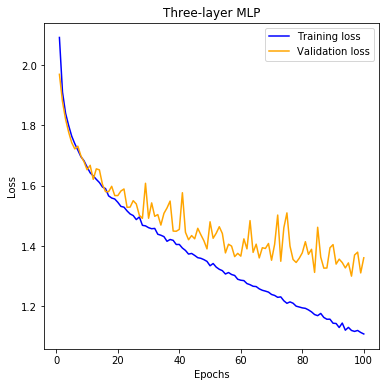

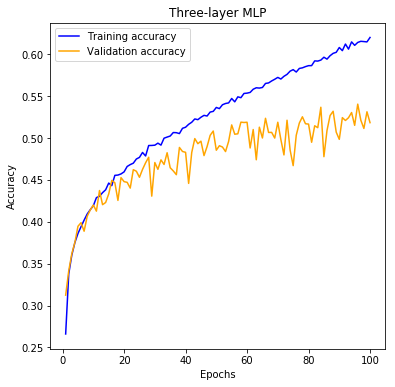

In [14]:
# Plot of Losses
history_dict_3 = history_3.history
# history_dict.keys()
loss_values_3 = history_dict_3['loss']
val_loss_values_3 = history_dict_3['val_loss']
acc_values_3 = history_dict_3['acc']
val_acc_values_3 = history_dict_3['val_acc']

epochs_index = range(1,len(loss_values_3)+1)
fig_loss_3 = plt.figure(figsize=(6, 6))
plt.plot(epochs_index, loss_values_3, 'b', label='Training loss')
plt.plot(epochs_index, val_loss_values_3, 'b', c='orange', label='Validation loss')
plt.title('Three-layer MLP')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



#%%
# Plot of Accuracies
plt.clf()
fig_accuracy_3 = plt.figure(figsize=(6, 6))
plt.plot(epochs_index,acc_values_3,'b', label='Training accuracy')
plt.plot(epochs_index,val_acc_values_3,'b', c='orange', label='Validation accuracy')
plt.title('Three-layer MLP')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Save the Plots

In [15]:
fig_accuracy_3.savefig('fig_accuracy_cifar_3.eps', format='eps', dpi=2000)